## Load libraries

In [177]:
import xarray as xr
import numpy as np
import pandas as pd
import earthaccess
import xarray as xr
import sys

## Open the in-situ data file and subset
* For the PACE time period (beginning March 2024)
* For a specific station (e.g., "SIO")

In [178]:
df_insitu = pd.read_csv('calhabs_data.csv')
df = df_insitu[(df_insitu['date'] >= '2024-03-05') & (df_insitu['Location_Code'] == 'SIO')]
#df = df_insitu[(df_insitu['date'] >= '2024-03-05')]
df.head()

,Location_Code,latitude,longitude,time,date,Temp,Avg_Chloro,pDA,tDA,Pn_delicatissima,Pn_seriata
72,SIO,32.867,-117.257,2024-03-11T19:15:00Z,2024-03-11,15.9,2.75,0.0,NaN,1252.0,0.0
78,SIO,32.867,-117.257,2024-03-18T19:00:00Z,2024-03-18,16.6,3.39,0.0,NaN,13768.0,6884.0
84,SIO,32.867,-117.257,2024-03-25T19:34:00Z,2024-03-25,15.3,2.91,0.0,NaN,4381.0,4381.0
91,SIO,32.867,-117.257,2024-04-01T19:27:00Z,2024-04-01,14.8,3.68,0.0,NaN,13142.0,6884.0
100,SIO,32.867,-117.257,2024-04-08T19:53:00Z,2024-04-08,15.6,2.13,0.0,NaN,1252.0,0.0


## Extract PACE data
### Create file finder function

In [179]:
def pace_file_finder(start_time, end_time, short_id="PACE_OCI_L3M_RRS", granule_pattern="*.8D.*.4km.*"):
    results = earthaccess.search_data(
        short_name=short_id,
        temporal=(start_time, end_time),
        granule_name=granule_pattern  # Use the variable here
    ) # Close the search_data function properly
    #fileset = earthaccess.open(results, show_progress=False)

    return earthaccess.open(results) # Return the results after the call is complete

## Set up Earthdata login

In [164]:
auth = earthaccess.login()

## Extract PACE data for each station

In [180]:

# 2. Prepare a list to collect the data rows
extracted_data = []
last_date = '2022-01-01'
# 3. Iterate through  DataFrame rows
for index, row in df.iterrows():
    # Find nearest indices for the target lat/lon

    #pace_file_finder(row['date']).argmin(), row['date']).argmin())
    print('station', row['Location_Code'])
    if last_date != row['date']:
        fileset = pace_file_finder(row['date'], row['date'])
        #fileset = earthaccess.open(results)
        last_date = row['date']
    if len(fileset) == 0:
            # If no files found, append an array of NaNs the same size as your wavelengths
        mean_spectrum_np = np.full(172, np.nan)
        print('fill with nans', row['date'])
    else:
        with xr.open_dataset(fileset[0]) as ds:
            print('fill with data', row['date'])
            if 'wavelengths' not in globals():
                wavelengths = ds["wavelength"].values
            
            lat_idx = int(np.abs(ds.lat - row['latitude']).argmin())
            lon_idx = int(np.abs(ds.lon - row['longitude']).argmin())
            if row['Location_Code'] == 'SIO' or row['Location_Code'] == 'NP':  # West
                lon_slice = slice(lon_idx - 8, lon_idx + 1)
                lat_slice = lat_idx
                mean_coord = "lon"
            elif (
                row['Location_Code'] == 'CPP' # South
                or row['Location_Code'] == 'HAB_SCW'
                or row['Location_Code'] == 'SW'
                or row['Location_Code'] == 'TP'
            ):
                lon_slice = lon_idx
                lat_slice = slice(lat_idx, lat_idx + 9)
                mean_coord = "lat"
            elif row['Location_Code'] == 'MB':   # North
                lat_slice = slice(lat_idx - 8, lat_idx + 1)
                lat_slice = lat_idx
                mean_coord = "lat"
            else:  # Southwest
                lat_slice = slice(lat_idx, lat_idx + 3)
                lon_slice = slice(lon_idx - 2, lon_idx + 1)
                mean_coord = ["lat", "lon"]

            #lon_slice = slice(lon_idx - 9, lon_idx + 1)

            mean_spectrum = ds["Rrs"].isel(
                lat=lat_slice, 
                lon=lon_slice
            ).mean(dim=mean_coord)
            mean_spectrum_np = mean_spectrum.values

    print('Done', row['date'])
    extracted_data.append(mean_spectrum_np)

        #sys.exit()

rrs_column_names = [f"Rrs_{w}" for w in wavelengths]
spectra_df = pd.DataFrame(extracted_data, columns=rrs_column_names, index=df.index)

    # 5. Concatenate the new columns to your original DataFrame
df = pd.concat([df, spectra_df], axis=1)

df.to_csv('cal_habs_filled_rrs.csv', index=False)


station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-03-11
Done 2024-03-11
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-03-18
Done 2024-03-18
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-03-25
Done 2024-03-25
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-04-01
Done 2024-04-01
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-04-08
Done 2024-04-08
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-04-15
Done 2024-04-15
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-04-22
Done 2024-04-22
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-04-29
Done 2024-04-29
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-05-06
Done 2024-05-06
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-05-13
Done 2024-05-13
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-05-20
Done 2024-05-20
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-05-28
Done 2024-05-28
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-06-03
Done 2024-06-03
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-06-10
Done 2024-06-10
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-06-17
Done 2024-06-17
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-06-24
Done 2024-06-24
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-07-01
Done 2024-07-01
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-07-08
Done 2024-07-08
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-07-15
Done 2024-07-15
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-07-22
Done 2024-07-22
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-07-29
Done 2024-07-29
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-08-05
Done 2024-08-05
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-08-12
Done 2024-08-12
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-08-19
Done 2024-08-19
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-08-26
Done 2024-08-26
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-09-03
Done 2024-09-03
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-09-09
Done 2024-09-09
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-09-16
Done 2024-09-16
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-09-23
Done 2024-09-23
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-09-30
Done 2024-09-30
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-10-07
Done 2024-10-07
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-10-14
Done 2024-10-14
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-10-21
Done 2024-10-21
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-10-28
Done 2024-10-28
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-11-04
Done 2024-11-04
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-11-11
Done 2024-11-11
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-11-18
Done 2024-11-18
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-11-25
Done 2024-11-25
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-12-02
Done 2024-12-02
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-12-09
Done 2024-12-09
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-12-16
Done 2024-12-16
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-12-23
Done 2024-12-23
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2024-12-30
Done 2024-12-30
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-01-06
Done 2025-01-06
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-01-13
Done 2025-01-13
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-01-21
Done 2025-01-21
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-01-27
Done 2025-01-27
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-02-03
Done 2025-02-03
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-02-10
Done 2025-02-10
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-02-18
Done 2025-02-18
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-02-24
Done 2025-02-24
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-03-04
Done 2025-03-04
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-03-10
Done 2025-03-10
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-03-17
Done 2025-03-17
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-03-24
Done 2025-03-24
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-03-31
Done 2025-03-31
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-04-07
Done 2025-04-07
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-04-14
Done 2025-04-14
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-04-21
Done 2025-04-21
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-04-28
Done 2025-04-28
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-05-05
Done 2025-05-05
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-05-12
Done 2025-05-12
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-05-19
Done 2025-05-19
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-05-27
Done 2025-05-27
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-06-02
Done 2025-06-02
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-06-09
Done 2025-06-09
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-06-16
Done 2025-06-16
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-06-23
Done 2025-06-23
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-06-30
Done 2025-06-30
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-07-07
Done 2025-07-07
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-07-14
Done 2025-07-14
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-07-21
Done 2025-07-21
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-07-28
Done 2025-07-28
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-08-04
Done 2025-08-04
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-08-11
Done 2025-08-11
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-08-18
Done 2025-08-18
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-08-25
Done 2025-08-25
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-09-02
Done 2025-09-02
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-09-08
Done 2025-09-08
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-09-15
Done 2025-09-15
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-09-22
Done 2025-09-22
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-09-29
Done 2025-09-29
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-10-06
Done 2025-10-06
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-10-13
Done 2025-10-13
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-10-20
Done 2025-10-20
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-10-27
Done 2025-10-27
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-11-03
Done 2025-11-03
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-11-10
Done 2025-11-10
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-11-17
Done 2025-11-17
station SIO


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

fill with data 2025-11-24
Done 2025-11-24
station SIO
fill with nans 2025-12-01
Done 2025-12-01
station SIO
fill with nans 2025-12-08
Done 2025-12-08
station SIO
fill with nans 2025-12-15
Done 2025-12-15
station SIO
fill with nans 2025-12-22
Done 2025-12-22
station SIO
fill with nans 2025-12-29
Done 2025-12-29
station SIO
fill with nans 2026-01-05
Done 2026-01-05
station SIO
fill with nans 2026-01-12
Done 2026-01-12


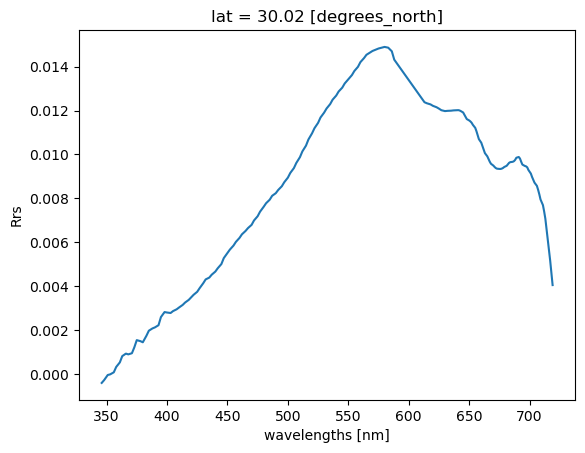

In [30]:
mean_west_center.plot()